# Proyecto del Curso

**ISIS4227 - Introducción a la Computación Cuántica**

Nicolás Rincón Sánchez - 202021963

## Planteamiento del Problema

El Problema de Monty Hall, inspirado en un popular programa de televisión, plantea un intrigante dilema probabilístico. El presentador, Monty Hall, le pide al concursante que elija una de tres puertas, detrás de una de las cuales se esconde un premio, mientras que las otras dos no tienen premio alguno. Después de que el concursante anuncia en voz alta su elección, sin abrir la puerta, Monty abre una de las otras dos puertas, asegurándose siempre de revelar una puerta sin premio. En este punto, quedan dos puertas cerradas: la que el concursante eligió inicialmente y otra más. El premio está detrás de una de estas dos puertas, pero el concursante no sabe cuál. Entonces, Monty formula la pregunta crucial: "¿Quiere cambiar su elección de puerta?"

A primera vista, pareciera que no importa si cambia o no. Esto debido a que la elección entre dos puertas tiene una probabilidad de éxito del 50%. Sin embargo, la realidad es que cambiar de puerta aumenta la probabilidad de ganar hasta un 66.6%. A través de este proyecto, se busca simular con un circuito cuántico las condiciones del escenario del juego de Monty Hall, así como las decisiones que se toman a lo largo de este, empleando la naturaleza puramente probabilística de la Mecánica Cuántica. De esta manera, se espera llegar a resultados que concuerden con la probabilidad de ganancia teórica del cambio de puerta, mediante simulación y experimentación en máquinas de IBM.

## Desarrollo de la Solución

Se importan las librerías de Python y de Qiskit relevantes para el desarrollo del circuito cuántico.

In [1]:
import numpy as np
import math as m

# Importing standard Qiskit libraries
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from qiskit_aer import QasmSimulator
from qiskit.visualization import plot_histogram

### Preparación de los Estados

Para el diseño del circuito, se tiene en cuenta la representación de las tres puertas del problema. Cada una de las puertas se representa por medio de un Qubit, donde el estado $\ket{0}$ representa que hay un diamante detrás de dicha puerta y el estado $\ket{1}$ representa que la puerta está vacía.

Debido a la naturaleza de la configuración inicial, sólo una de las puertas contiene el diamante, mientras que las otras dos se encuentran vacías. En ese orden de ideas, según la representación de los estados definida para los tres Qubits iniciales, estas deben encontrarse en uno de los siguientes tres estados: $\ket{011}$, $\ket{101}$ y $\ket{110}$. Adicionalmente, como es equiprobable la presencia del diamante en cualquiera de las tres puertas, es necesario que cada uno de los tres estados anteriores tenga amplitud de probabilidad de $\frac{1}{\sqrt{3}}$. Es una versión inversa al estado W presentado en `[3]`.

También se recurre a un cuarto Qubit para un paso posterior que se inicializa en el estado $\ket{0}$ por defecto, por lo cual, se concluye que el circuito requiere una primera etapa de preparación de los estados que culmine con la superposición del estado:
$$\frac{1}{\sqrt{3}} (\ket{0011}+\ket{0101}+\ket{0110})$$

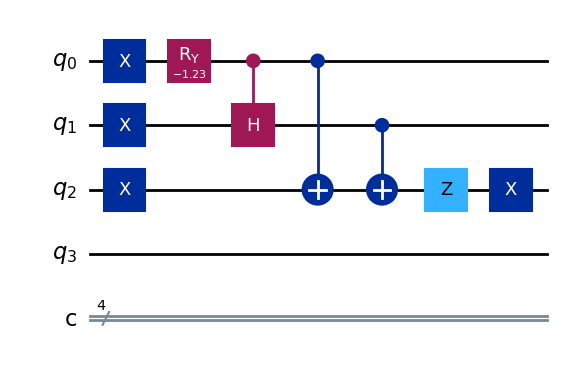

In [2]:
# Crear un circuito cuántico con 4 qubits y 4 registros clásicos
qc = QuantumCircuit(4, 4)

# Se debe inicializar los estados de las puertas en |1> y transformar desde ahí
qc.x(0)
qc.x(1)
qc.x(2)

# Aplicar una rotación en el eje Y para ir generando la probabilidad de 1/3
theta = 2*m.asin(-m.sqrt(1/3))
qc.ry(theta, 0)

# Aplicar una compuerta Hadamard controlada por el Qubit 0 sobre el Qubit 1
qc.ch(0, 1)

# Aplicar compuertas CNOT sobre los Qubits 0 y 1
qc.cx(0, 2)
qc.cx(1, 2)

# Ajustar la fase y el estado del Qubit 2
qc.z(2)
qc.x(2)

# Dibujar el circuito hasta este punto (Preparación de los Estados de las puertas)
qc.draw('mpl')

El desarrollo del fragmento anterior se realizó con base en lo presentado en `[1]` y `[2]`, pero modificado para que los estados que representen el diamante correspondan a $\ket{0}$ en vez de $\ket{1}$. Para determinar el ángulo de rotación de la matriz Ry, se tuvo en cuenta que se debía compensar el Phase Kickback de los Qubits de control (es decir, negar el ángulo de la rotación), por lo cual, se determinó el cálculo sobre un Qubit en estado $\ket{1}=\begin{pmatrix}0\\1\end{pmatrix}$, de la siguiente manera:

$$R_Y(-\theta)\ket{1} \longrightarrow \sin{\left(\frac{\theta}{2}\right)} = -\frac{1}{\sqrt{3}}$$
$$\theta = -2\arcsin{\left(\frac{1}{\sqrt{3}}\right)} \approx -1.23092...$$

Dicha construcción se logró por medio de la plataforma Composer de IBM Quantum Learning.

In [3]:
# Ubicamos una barrera para separar la primera etapa del circuiot
qc.barrier(0,1,2,3);

### Selección de la Puerta

Siguiendo el proceso de Monty Hall, el siguiente paso consiste en elegir una de las puertas como primera decisión. Debido a que las tres puertas tienen la misma probabilidad en este momento de la preparación, es válido asumir como elegida una misma puerta, sin pérdida de generalidad. De esta manera, asumimos que la puerta que escoge el concursante es siempre la primera (que se encuentra representada por el Qubit $q[0]$). Esta puerta es la que se abre sólo hasta el final.

A continuación, vamos a emplear el cuarto Qubit ($q[3]$) para representar la decisión de abrir la segunda o la tercera puerta ($q[1]$ o $q[2]$). Esta es la puerta abierta por el presentador antes de preguntarle al concursante si desea cambiar de puerta o no. En esta oportunidad, para el cuarto Qubit, los estados van a representar algo diferente: el estado $\ket{0}$ representa la apertura de la segunda puerta (el Qubit $q[1]$) y el estado $\ket{1}$ representa la apertura de la tercera puerta (el Qubit $q[2]$). Todo esto siempre bajo el supuesto que el concursante selecciona la primera puerta.

El escenario puede tomar una y solo una de las siguientes tres posibilidades:

* **El premio está en la puerta $q[0]$**: Esto implica que el presentador puede abrir cualquiera de las otras dos puertas con la misma probabilidad, ninguna está favorecida respecto a la otra.
* **El premio está en la puerta $q[1]$**: Esto implica que el presentador debe abrir necesariamente la tercera puerta ($q[2]$) porque no puede abrir la primera que el concursante seleccionó.
* **El premio está en la puerta $q[2]$**: Esto implica que el presentador debe abrir necesariamente la segunda puerta ($q[1]$) porque no puede abrir la primera que el concursante seleccionó.

A partir de este razonamiento, se decide emplear una Compuerta Toffoli para poder llevar el cuarto Qubit al estado $\ket{1}$ controlado por el primer y el segundo Qubit, es decir, cuando ocurra el Caso 2 mencionado anteriormente. De esta manera, se representa la apertura de la puerta $q[2]$.

Ahora bien, para simular el Caso 1, es necesario poner el cuarto Qubit en superposición con una Compuerta Hadamard debido a que cualquiera de las otras puertas se puede abrir con la misma factibilidad. Sin embargo, para representar la Compuerta Hadamard controlada por dos Qubits, fue necesario realizar Transpilado pues Qiskit no la maneja. Se utilizó la equivalencia mostrada en `[2]` para tal fin.

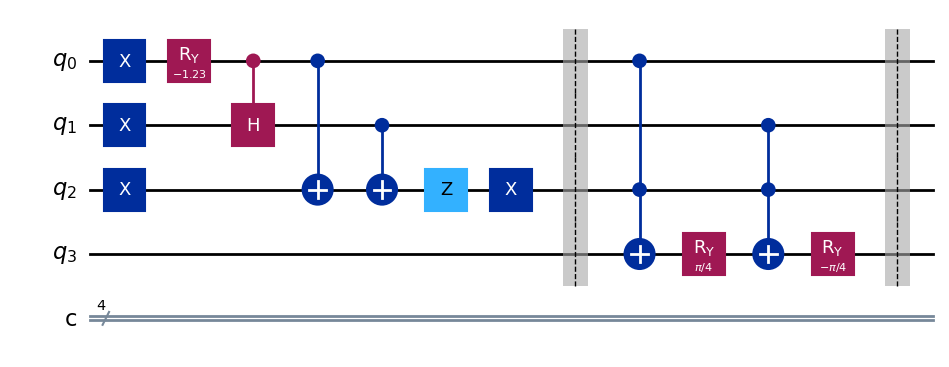

In [4]:
# Aplicar una CNOT para representar el Caso 2
qc.ccx(0, 2, 3)

# Aplicar el Transpilado de la Hadamard Doble Controlada
qc.ry(m.pi/4, 3)
qc.ccx(1, 2, 3)
qc.ry(-m.pi/4, 3)

# Crear una barrera para separar la segunda etapa del circuito
qc.barrier(0,1,2,3);

# Dibujar el circuito hasta acá
qc.draw('mpl')

### Intercambio de la Puerta

Finalmente, el presentador abre la puerta. Dicha puerta se encuentra vacía por convención. En este momento, se emplea un Swap controlado para intercambiar la puerta cerrada con la puerta seleccionada. La hipótesis estadística que se busca probar es que la estrategia del cambio de puerta es efectiva en aproximadamente 2/3 de los casos. Por ende, en esta última etapa, se intercambian la puerta seleccionada y la puerta cerrada. Se realizó un ajuste respecto a la propuesta del Anteproyecto para no requerir la medición del cuarto Qubit sino emplear la naturaleza probabilística de los estados en todo momento.

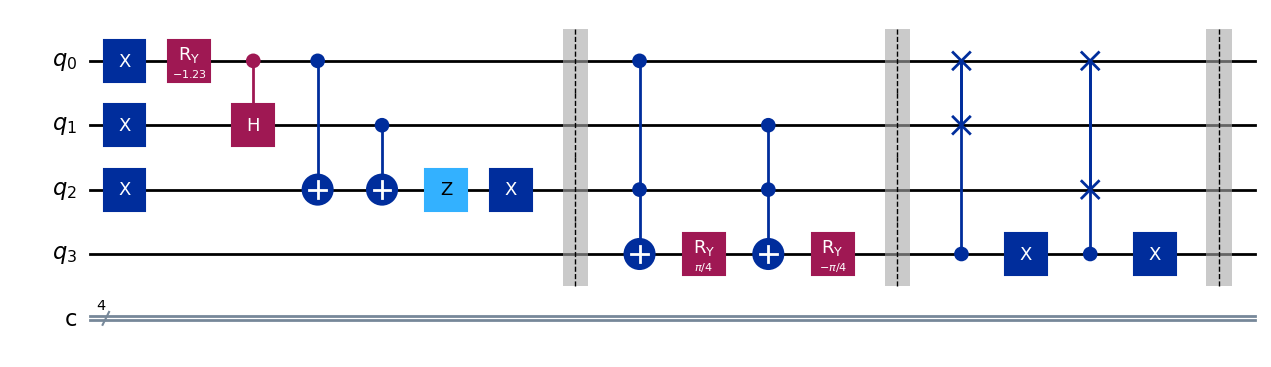

In [5]:
# Aplicar un SWAP Controlado -> Caso 2
qc.cswap(3, 0, 1)

# Aplicar un SWAP Controlado -> Caso 1
qc.x(3)
qc.cswap(3, 0, 2)
qc.x(3)

qc.barrier(0,1,2,3);
# Dibujar el circuito hasta acá
qc.draw('mpl')

Finalmente, se agrega la medición para cada uno de los Qubits, para completar el circuito.

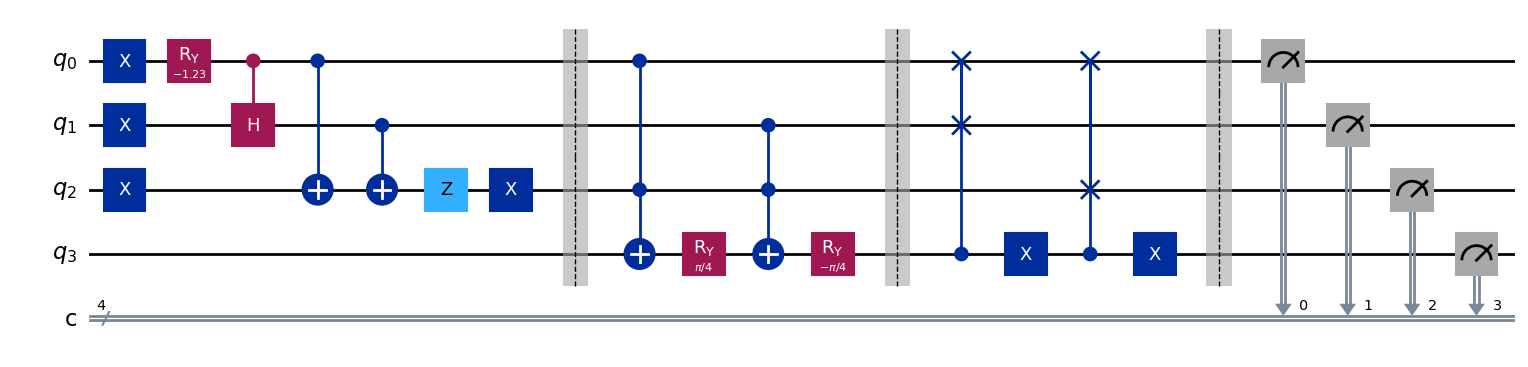

In [6]:
# Agregar las mediciones de todos los Qubits
qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)
qc.measure(3, 3)

# Dibujar el circuito completo
qc.draw('mpl')

## Simulación en BackEnd

Se crea un backend local para ejecutar una simulación del circuito para 1024 pruebas.

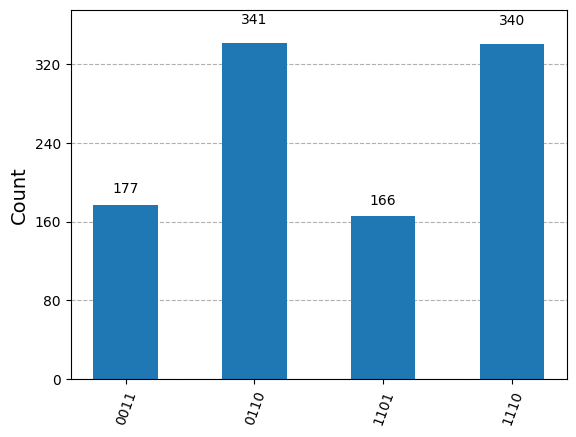

In [7]:
# Histograma para contar estados con 1024 intentos
sampler = StatevectorSampler()
job_sampler = sampler.run([qc], shots=1024)
results = job_sampler.result()[0].data.c.get_counts()
plot_histogram(results)

Debido a la convención de medición y de representación del premio que se utilizaron, los estados que finalizan en 0 corresponden con aquellos en los cuales se detectó el premio correctamente tras el intercambio de las puertas. Procedemos a clasificar entre intentos en los que se ganó y en los que se perdió.

{'Gana': 681, 'Pierde': 343}


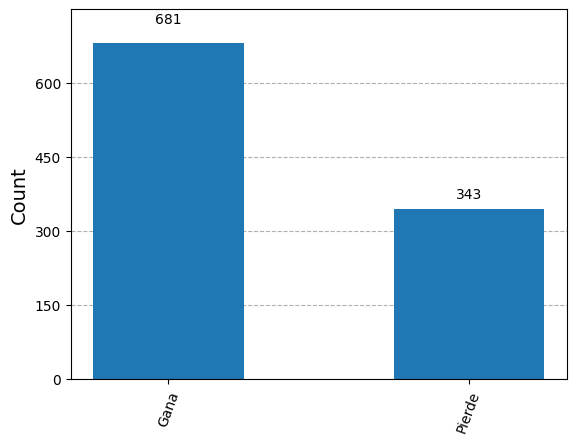

In [8]:
# Clasificar los resultados en GANAR y PERDER
monty_hall = {'Gana': 0, 'Pierde': 0}

for key, value in results.items():
    if key[-1] == '0':
        monty_hall['Gana'] += value
    else:
        monty_hall['Pierde'] += value

print(monty_hall)
plot_histogram(monty_hall)

In [10]:
# Imprimir las probabilidades de Ganar y Perder
print("Probabilidad de Ganar: " + str(monty_hall['Gana']/1024))
print("Probabilidad de Perder: " + str(monty_hall['Pierde']/1024))

Probabilidad de Ganar: 0.6650390625
Probabilidad de Perder: 0.3349609375


## Ejecución en Máquina de IBM

A continuación, se ejecuta un Servicio de IBM para correr el circuito simulado en una máquina real. Para ello, se sigue el protocolo de solicitud de un computador cuántico y encolamiento. Así mismo, se realiza el Transpilado del circuito a las compuertas disponibles en el hardware.

In [63]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

service = QiskitRuntimeService()

In [64]:
backend = service.least_busy(simulator=False, operational=True)
print(backend.configuration().backend_name)
print(backend.status().pending_jobs)

ibm_osaka
552


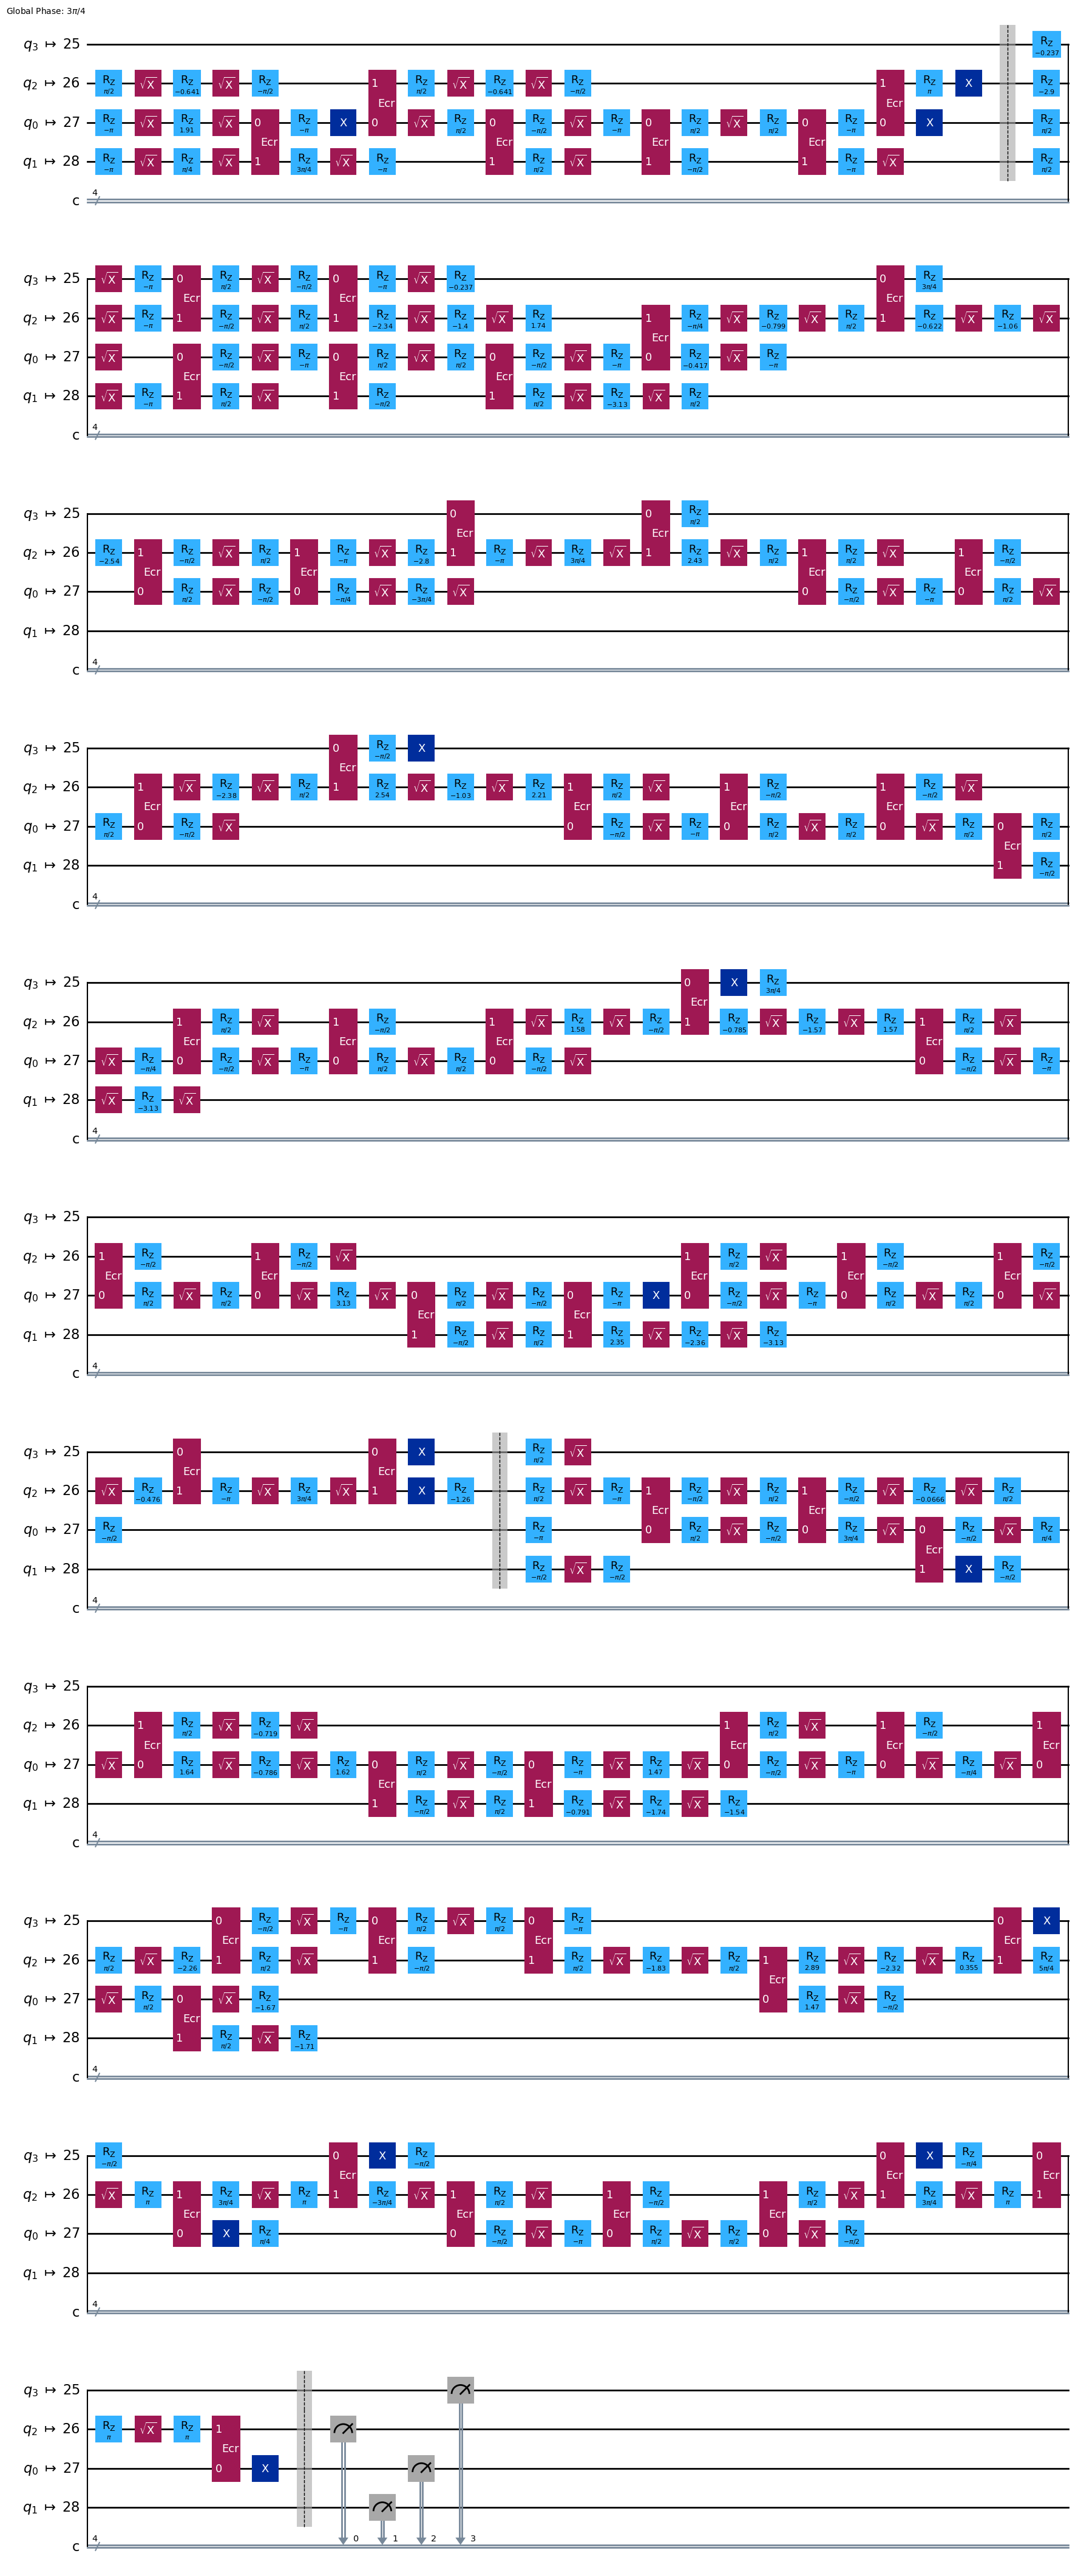

In [66]:
# Conversión al circuito transpilado
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qc)
 
isa_circuit.draw('mpl', idle_wires=False)

Se puede apreciar que la solución es bastante compleja pues se requiere de un número considerablemente mayor de compuertas para obtener el resultado equivalente. Así mismo, se puede observar que la fase global del circuito es $\theta=\frac{3\pi}{2}$.

In [47]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(backend)
 
job = sampler.run([isa_circuit])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: ctfywnjzhysg008rtywg
>>> Job Status: QUEUED


In [61]:
print(f">>> Job Status: {job.status()}")

>>> Job Status: DONE


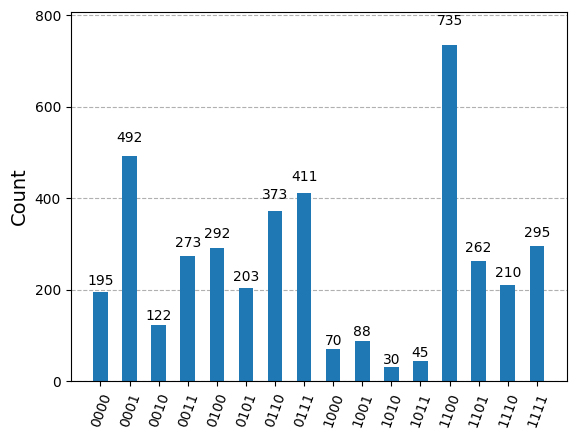

In [62]:
results1 = job.result()
plot_histogram(results1[0].data.c.get_counts())

Se realiza el mismo proceso de clasificación e impresión de las probabilidades de ganancia y pérdida con los resultados de ejecución en la máquina real de IBM. Se puede apreciar, sin embargo, que la máquina de IBM permitió que pasaran estados prohibídos. Por ejemplo, estados en los que hay tres puertas con y sin premio. Esto se debe a que, durante el proceso de Transpilado, el optimizador no necesariamente encontró la equivalencia exacta para generar el estado $\frac{1}{\sqrt{3}}(\ket{0110}+\ket{0101}+\ket{0011})$ y a partir de ahí, permitió que se filtraran estos estados. Esto debido a que no es el estado W puro sino una variación de este.

Se procede con la clasificación para "Gana", "Pierde" y se agrega una categoría de "Error" para los estados que no deberían aparecer:

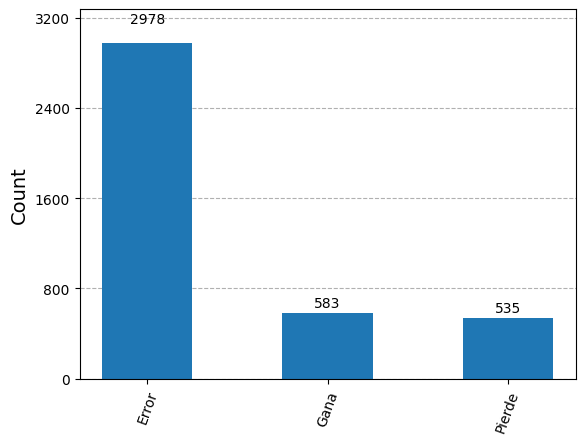

In [67]:
monty_hall_ibm = {'Gana': 0, 'Pierde': 0, 'Error': 0}

for key, value in results1[0].data.c.get_counts().items():
    if key in {'0110', '1110'}:
        monty_hall_ibm['Gana'] += value
    elif key in {'0011', '1101'}:
        monty_hall_ibm['Pierde'] += value
    else:
        monty_hall_ibm['Error'] += value

plot_histogram(monty_hall_ibm)

In [68]:
print("Probabilidad de Ganar: " + str(monty_hall_ibm['Gana']/(monty_hall_ibm['Gana'] + monty_hall_ibm['Pierde'])))
print("Probabilidad de Perder: " + str(monty_hall_ibm['Pierde']/(monty_hall_ibm['Gana'] + monty_hall_ibm['Pierde'])))

Probabilidad de Ganar: 0.5214669051878354
Probabilidad de Perder: 0.4785330948121646


La máquina de IBM no logró simular correctamente la proporción $\frac{2}{3}-\frac{1}{3}$. Además, debido a la carga en los servidores públicos, no se realizó una segunda prueba.

## Otra Alternativa

Decidí realizar un segundo circuito muy similar al primero, pero con una estrategia de intercambio de las compuertas basadas en la medición inicial del estado del Qubit $q[3]$ más semejante a lo que planteé en el Anteproyecto. Esto debido a que, al abrir una de las dos puertas y ver que está vacía, teóricamente se está colapsando la Función de Onda asociada a la probabilidad de dicho Qubit. De esta manera, en realidad, se está renormalizando la probabilidad desde los estados con $q[3]\in\{0,1\}$ a aquellos en los que $q[3]$ toma sólo un valor específico.

De esta manera, se emplea un Protocolo similar al de Teleportación, en el cual se cruzan registros cuánticos con registros clásicos. En mi caso, he optado por aplicar los intercambios de puerta (es decir, las compuertas SWAP de la tercera etapa) a partir de una medición condicional realizada sobre el registro clásico en el que se mide el valor del Qubit $q[3]$.

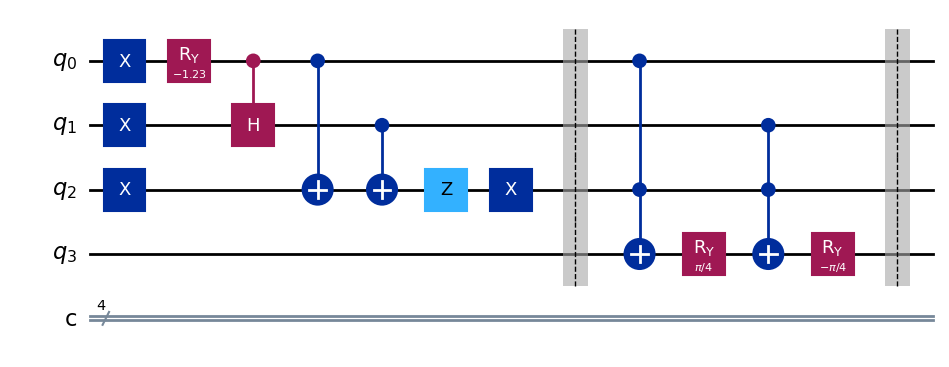

In [16]:
# Se repiten las primeras dos etapas del circuito
qc_alt = QuantumCircuit(4, 4)


# Preparación de los Estados de las puertas
qc_alt.x(0)
qc_alt.x(1)
qc_alt.x(2)

theta = 2*m.asin(-m.sqrt(1/3))
qc_alt.ry(theta, 0)

qc_alt.ch(0, 1)

qc_alt.cx(0, 2)
qc_alt.cx(1, 2)

qc_alt.z(2)
qc_alt.x(2)

qc_alt.barrier(0,1,2,3);


# Selección de la Puerta
qc_alt.ccx(0, 2, 3)

qc_alt.ry(m.pi/4, 3)
qc_alt.ccx(1, 2, 3)
qc_alt.ry(-m.pi/4, 3)

qc_alt.barrier(0,1,2,3);


# Dibujar el circuito hasta acá
qc_alt.draw('mpl')

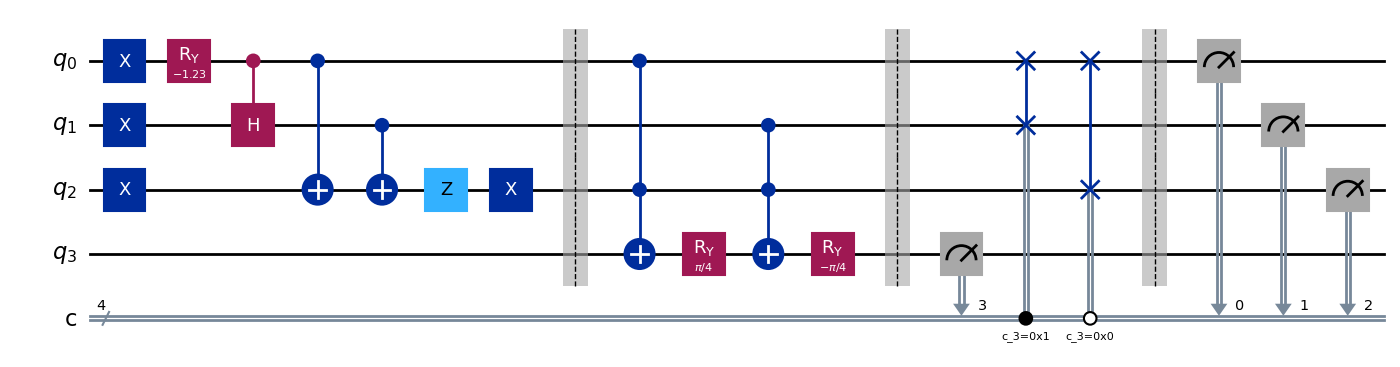

In [17]:
# Agregar la medición del cuarto Qubit
qc_alt.measure(3, 3)

# Agregar las compuertas SWAP condicionales
qc_alt.swap(0, 1).c_if(3, 1) # Cambiar con la segunda puerta si se abre la tercera
qc_alt.swap(0, 2).c_if(3, 0) # Cambiar con la primera puerta si se abre la segunda
qc_alt.barrier(0,1,2,3);

# Agregar las mediciones de los Qubits
qc_alt.measure(0, 0)
qc_alt.measure(1, 1)
qc_alt.measure(2, 2)

# Dibujar el circuito completo
qc_alt.draw('mpl')

Se repiten las pruebas en simulación realizadas con el primer circuito para verificar que ambas son soluciones correctas, no necesariamente equivalentes, pero que emplean las propiedades de la Mecánica Cuántica de los Qubits de diferente manera.

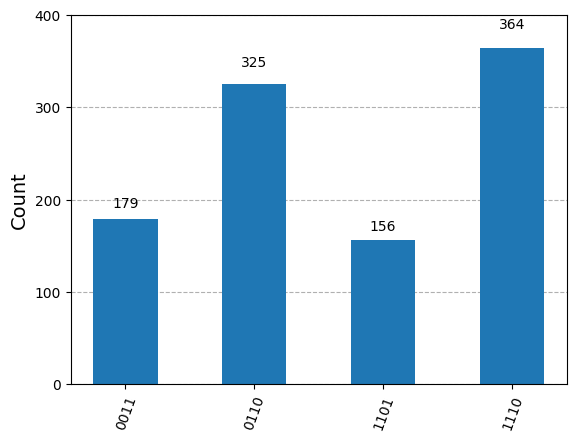

In [36]:
# Histograma para contar estados con 1024 intentos
sampler_alt = StatevectorSampler()
job_sampler_alt = sampler_alt.run([qc], shots=1024)
results_alt = job_sampler_alt.result()[0].data.c.get_counts()
plot_histogram(results_alt)

{'Gana': 689, 'Pierde': 335}


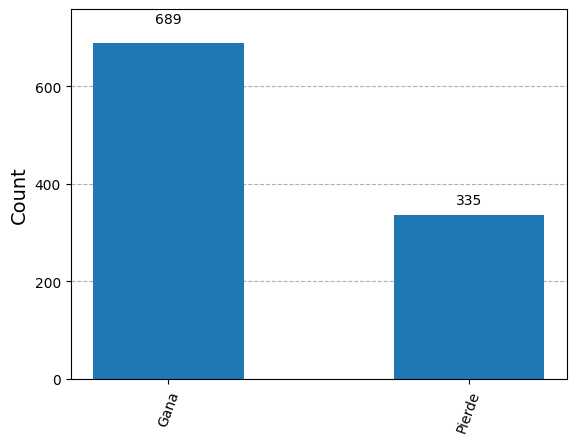

In [37]:
# Clasificar los resultados en GANAR y PERDER
monty_hall_alt = {'Gana': 0, 'Pierde': 0}

for key, value in results_alt.items():
    if key[-1] == '0':
        monty_hall_alt['Gana'] += value
    else:
        monty_hall_alt['Pierde'] += value

print(monty_hall_alt)
plot_histogram(monty_hall_alt)

In [38]:
# Imprimir las probabilidades de Ganar y Perder
print("Probabilidad de Ganar: " + str(monty_hall_alt['Gana']/1024))
print("Probabilidad de Perder: " + str(monty_hall_alt['Pierde']/1024))

Probabilidad de Ganar: 0.6728515625
Probabilidad de Perder: 0.3271484375


Nuevamente, se realiza el Transpilado del segundo circuito y se simula también en la máquina de IBM.

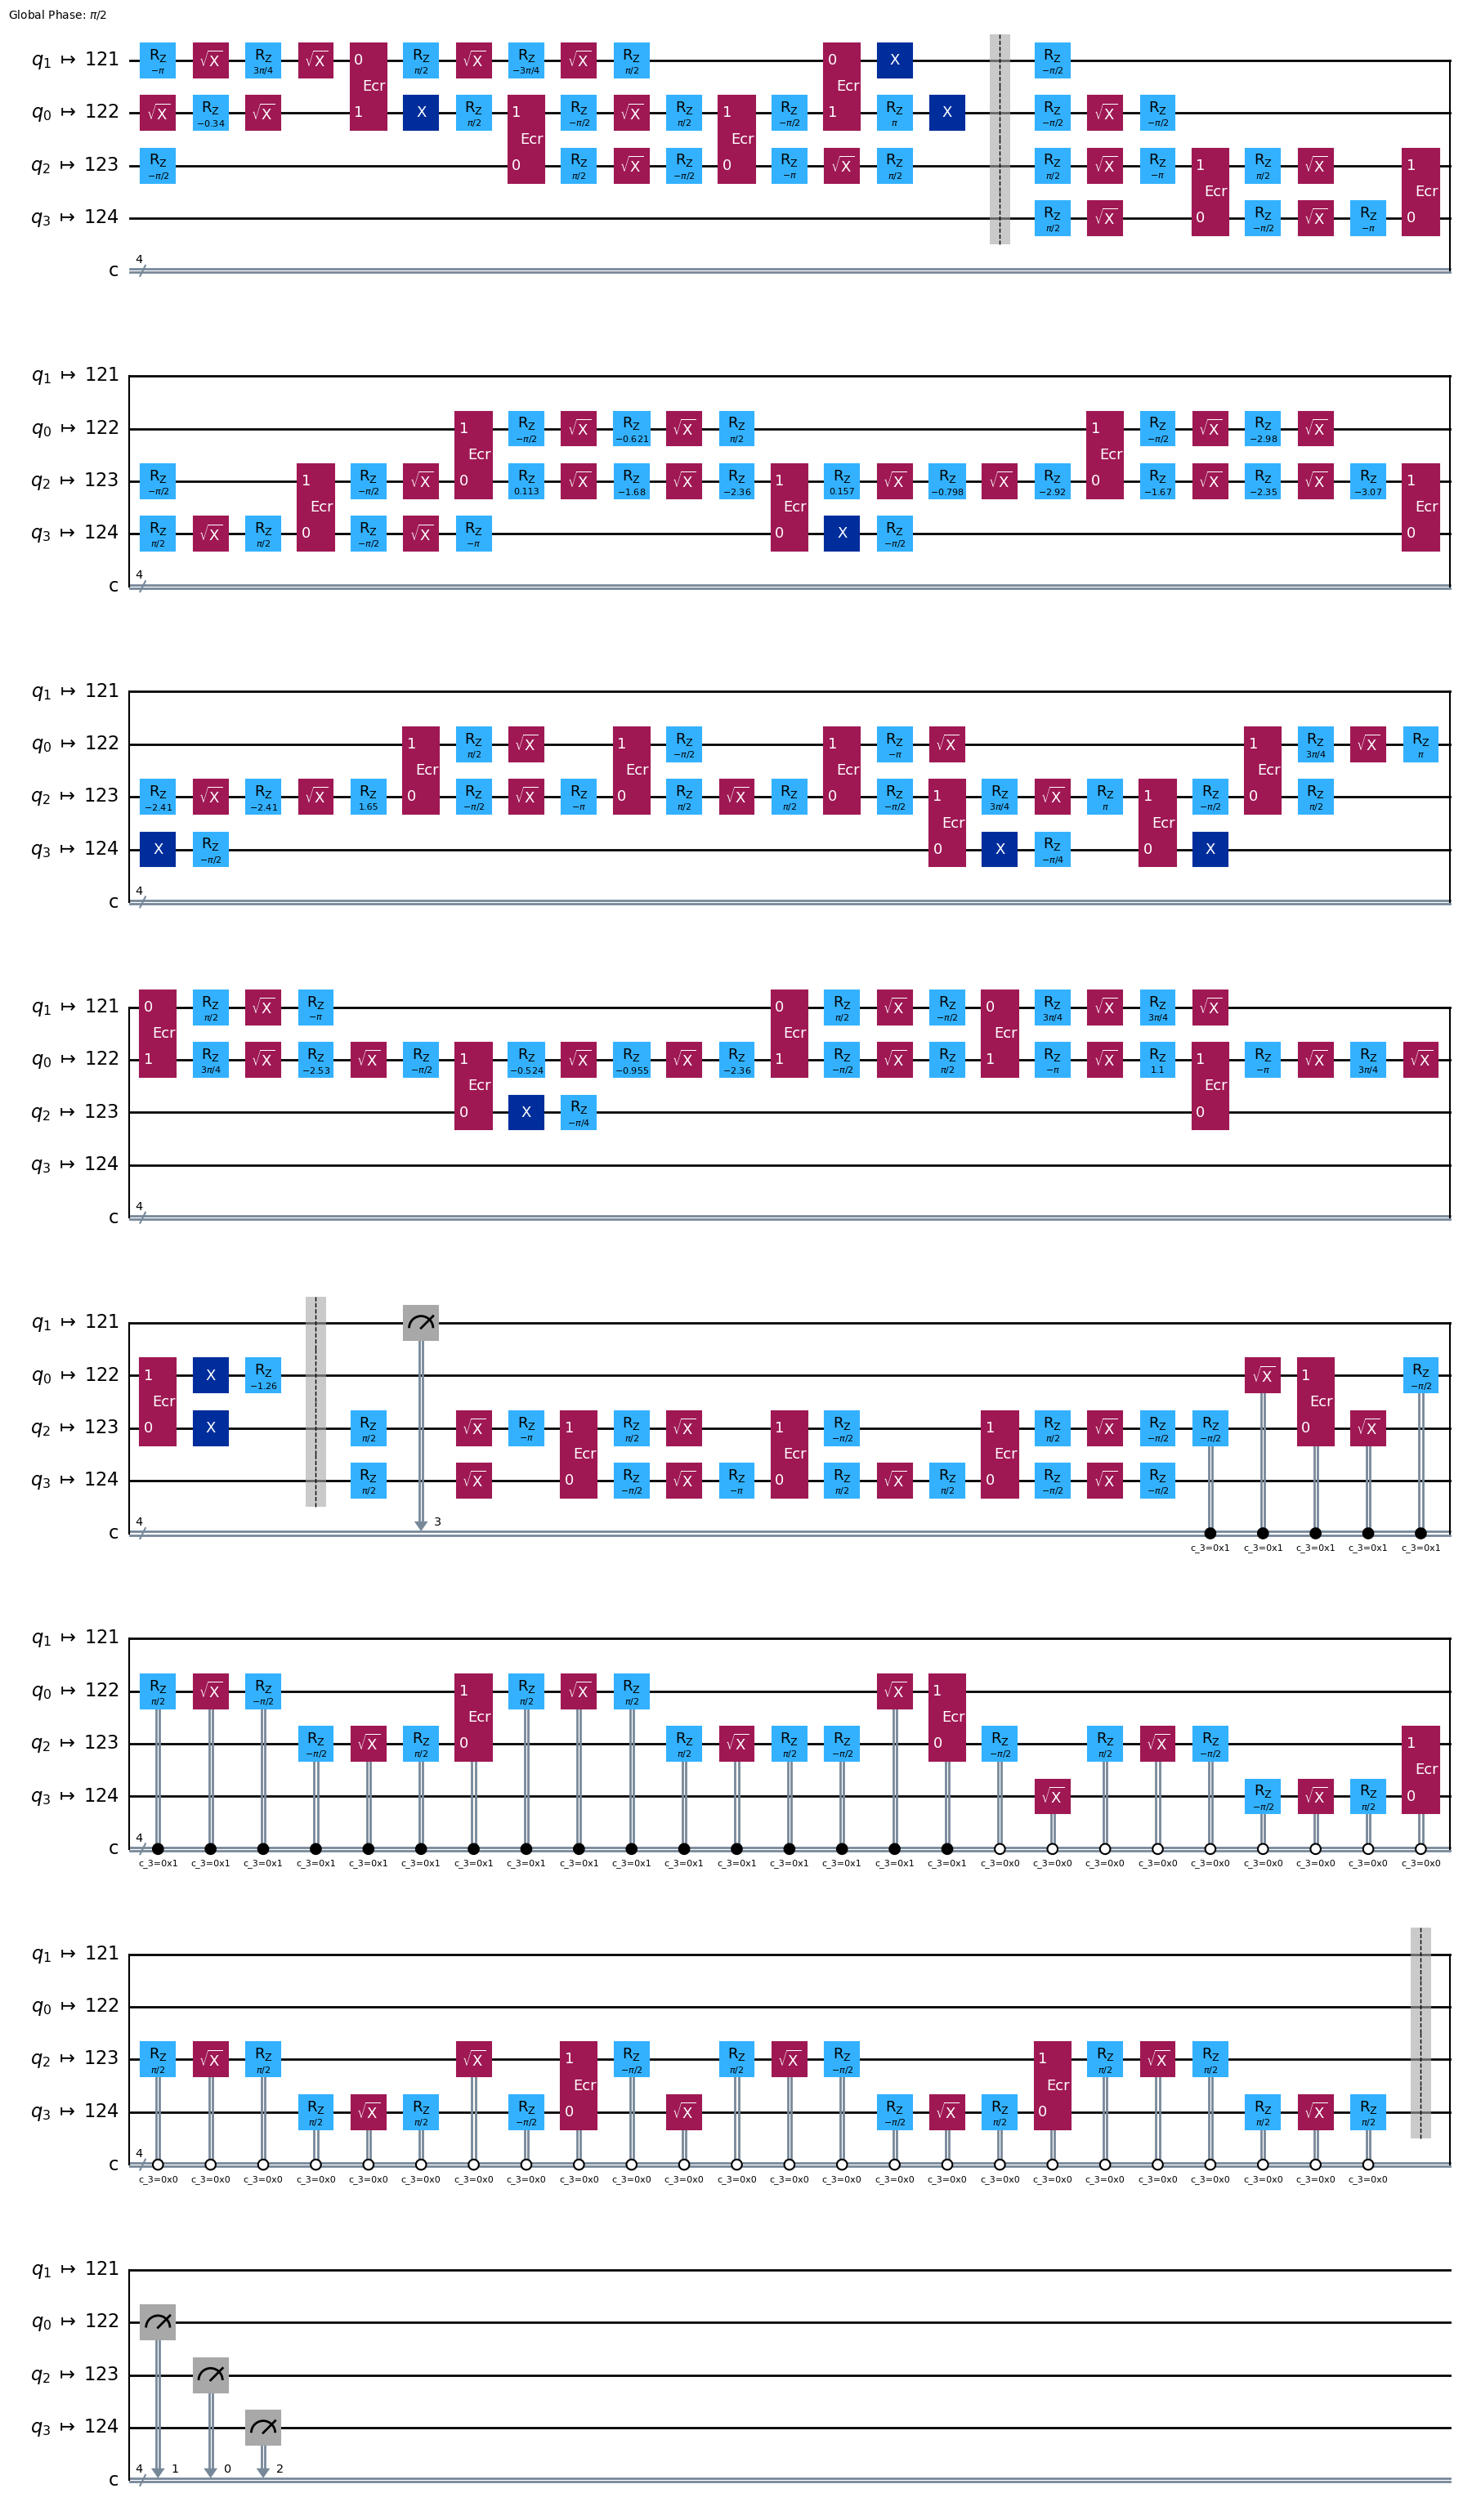

In [56]:
pm_alt = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit_alt = pm_alt.run(qc_alt)
 
isa_circuit_alt.draw('mpl', idle_wires=False)

In [57]:
sampler_alt = Sampler(backend)
 
job_alt = sampler_alt.run([isa_circuit_alt])
print(f">>> Job ID: {job_alt.job_id()}")
print(f">>> Job Status: {job_alt.status()}")

>>> Job ID: ctfyxn69fby0008fgkeg
>>> Job Status: QUEUED


In [69]:
print(f">>> Job Status: {job_alt.status()}")

>>> Job Status: ERROR


Al enviar a ejecución en la máquina de IBM, el resultado fue un error debido a que, según `[4]`, ninguna máquina de IBM actualmente tiene el hardware necesario para utilizar correctamente compuertas con condicionales. Debido a ello, se arrojó un error bfunc(). En consecuencia, el mejor circuito a optimizar y transpilar para simular correctamente el Problema de Monty Hall es el primero pues es el único que podría llevarse al hardware con el que cuenta IBM.

## Conclusiones

A partir de lo realizado en el proyecto, se puede concluir que la computación cuántica no solo es capaz de reproducir resultados teóricos de problemas probabilísticos clásicos como la Paradoja de Monty Hall, sino también de proporcionarles una validación estadística robusta y precisa. 

La validación estadística de la Paradoja de Monty Hall mediante dos circuitos cuánticos, con la simulación en el backend, proporcionó resultados coherentes y relativamente precisos. Los histogramas obtenidos en ambos escenarios muestran de manera consistente la relación entre las probabilidades de "Ganar" y "Perder" al cambiar de puerta. En particular, se observa que al optar por cambiar de puerta, la probabilidad de ganar se aproxima al 66.6% o $\frac{2}{3}$, mientras que al mantener la elección inicial, la probabilidad de ganar se reduce al 33.3% o $\frac{1}{3}$. 

Estos resultados estadísticos confirman la validez teórica de la Paradoja de Monty Hall y demuestran la efectividad de los circuitos cuánticos para modelar y analizar problemas probabilísticos. Ahora bien, la diferencia e inconsistencia entre los datos de simulación y los obtenidos en el Sampler de IBM resalta la limitación que hay detrás de los desarrollos más recientes en computación cuántica. De esta manera, permite dar cuenta de la importancia creciente que el desarrollo e implementación de este campo de estudio está teniendo en la actualidad y que tendrá en el futuro.

# Referencias

**[1]** Institut quantique de l'Université de Sherbrooke. (2022). *The Quantum Enigmas 004 - The Monty Hall problem.* Disponible en: https://www.youtube.com/watch?v=Hd9KhRts1uw&t=366s

**[2]** Bolos, S. (2020). *Simulating the Monty Hall Problem on a Quantum Computer.* Medium. Disponible en: https://medium.com/transilvaniaquantum/simulating-the-monty-hall-problem-on-a-quantum-computer-71613f54f0bf

**[3]** Cruz, D., Fournier, R., Gremion, F., Jeannerot, A., Komagata, K., Tosic, T., Thiesbrummel, J., Chan, C.L., Macris, N., Dupertuis, M.-A. and Javerzac-Galy, C. (2019). *Efficient Quantum Algorithms for GHZ and W States, and Implementation on the IBM Quantum Computer.* Adv. Quantum Technol., 2: 1900015. Disponible en: https://doi.org/10.1002/qute.201900015

**[4]** Quantum Computing Stack Exchange. (2021). Disponible en: https://quantumcomputing.stackexchange.com/questions/16710/please-help-interpret-the-ibm-quantum-error-code-instruction-bfunc-is-not-supp